In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
import os
import numpy as np
import re
import time
import logging

# check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(levelname)s %(asctime)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


# 01. Prepare the dataset
class IsingDataset(Dataset):
    def __init__(self, Tc, L=30):
        self.L = L
        BASE_DIR = "Data_configurations"

        # Prepare the data list
        data_list = []
        label_list = []

        # Read the data
        T_list = np.linspace(1.0, 3.5, 1000)
        T_list = T_list[::50]
        for temp in T_list:
            file = f"L{L}_T{temp:.4f}.npy"

            # Load file
            data_np = np.load(os.path.join(BASE_DIR, f"{L}", file))
            count = 0
            for ele in data_np[:100]:
                ele_flatten = ele.flatten()
                data_list.append(ele_flatten)
                count += 1

            # Prepare the label
            if temp < Tc:
                label_list.extend([0] * count)
            elif temp >= Tc:
                label_list.extend([1] * count)

        # Prepare the data and label tensor
        data_list = np.array(data_list)
        self.data = torch.tensor(data_list, dtype=torch.float32).to(device)
        self.label = torch.tensor(label_list, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

# 02. Define the model
class FNN(nn.Module):
    def __init__(self, L=30, hidden_dim=100, output_dim=2):
        input_dim = L * L
        super(FNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.fc(x)

[INFO 2024-12-23 15:17:02] L: 30, Temperature: 0.91, Accuracy: 1.0
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 1.13, Accuracy: 0.9
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 1.36, Accuracy: 0.85
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 1.59, Accuracy: 0.75
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 1.82, Accuracy: 0.784
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 2.04, Accuracy: 0.8975
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 2.27, Accuracy: 0.9815
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 2.50, Accuracy: 0.967
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 2.72, Accuracy: 0.8605
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 2.95, Accuracy: 0.787
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 3.18, Accuracy: 0.9
[INFO 2024-12-23 15:17:03] L: 30, Temperature: 3.40, Accuracy: 1.0
[INFO 2024-12-23 15:17:04] L: 30, Temperature: 3.63, Accuracy: 1.0
[INFO 2024-12-23 15:17:04] L: 60, Temperature: 0.91, Accuracy: 1.0
[INFO 2024-12-23 15:17:04] L: 60, Temperature

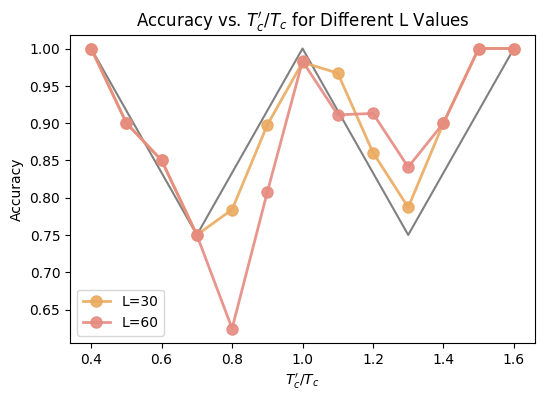

In [8]:
import numpy as np
import torch
import logging
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def Pc(cp: int) -> float:
    a = 0.4 * 2.269
    b = 1.6 * 2.269
    c = 2.269
    
    if cp < c:
        return 1 - min(c-cp, cp-a) / (b-a)
    else:
        return 1 - min(cp-c, b-cp) / (b-a)

# L是一个list
L_list = [30, 60]

Tc_list = np.linspace(0.4, 1.6, 13)
batch_size = 100

# 创建一个图形来绘制所有L的结果
plt.figure(figsize=(6, 4))

T_list = Tc_list * 2.269
Pc_list = [Pc(cp) for cp in T_list]

plt.plot(Tc_list, Pc_list, '-', color = 'gray')

color_list = ['#eaaa60', '#e68b81', '#b7b2d0', '#7da6c6', "#84c3b7"]

# 对每个L值进行循环
for L in L_list:
    accuracy_list = []  # 每个L的准确度列表
    for Tc in Tc_list:
        T = Tc * 2.269
        
        model_path = f"model_confusion_demo/{L}/model_{T:.2f}.pth"  # 假设每个L的模型路径不同
        model = FNN(L).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        Ising_dataset = IsingDataset(T, L)
        data_loader = DataLoader(Ising_dataset, batch_size=batch_size, shuffle=True)
        
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in data_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        
        accuracy = correct / total
        accuracy_list.append(accuracy)
        logging.info(f"L: {L}, Temperature: {T:.2f}, Accuracy: {accuracy}")

    # 在同一张图中绘制每个L的准确度曲线
    plt.plot(
        Tc_list, 
        accuracy_list, 
        '-',
        label=f"L={L}",  # 为每个L值添加标签
        alpha=0.9, 
        linewidth=2,  # 调整线条粗细
        marker='o',  # 添加点样式
        markersize=8,  # 调整点的大小
        color = color_list[L_list.index(L)]
    )

# 设置图表的标签和标题

plt.xlabel(r"$T_c'/T_c$")
plt.ylabel("Accuracy")
plt.title(r"Accuracy vs. $T_c'/T_c$ for Different L Values")
plt.legend()  # 显示图例
plt.savefig("fig_demo/W_shape.png", dpi=600, bbox_inches='tight')
plt.show()